In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import cv2  
import numpy as np
from PIL import Image
from numpy import clip
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from keras import optimizers

Using TensorFlow backend.


In [3]:
def read_image(filename):
    image1 = cv2.imread(filename)
    img = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    ret, img = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO)
    mean, std = img.mean(), img.std()
    img = (img  - mean) / std
    return img

In [4]:
im = Image.open("att-database-of-faces/s1/3.pgm")

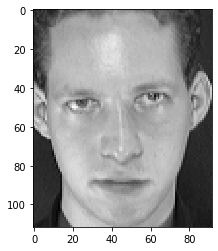

In [5]:
imshow(np.asarray(im), cmap='gray')

In [6]:
from matplotlib.pyplot import imshow
img = read_image('att-database-of-faces/s1/3.pgm')

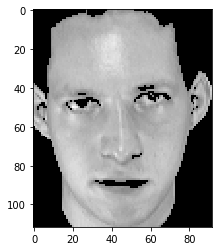

In [7]:
imshow(img, cmap='gray')

In [11]:
total_sample_size = 10000
n_of_persons = 35
size = 2
def get_data(size, total_sample_size):
    #read the image
    image = read_image('att-database-of-faces/s' + str(1) + '/' + str(1) + '.pgm')
    #reduce the size
    #image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]
    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(n_of_persons):
        for j in range(int(total_sample_size/n_of_persons)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('att-database-of-faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm')
            img2 = read_image('att-database-of-faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm')
            
            #reduce the size
#             img1 = img1[::size, ::size]
#             img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(n_of_persons)
                ind2 = np.random.randint(n_of_persons)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('att-database-of-faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm')
            img2 = read_image('att-database-of-faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm')

#             img1 = img1[::size, ::size]
#             img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [12]:
X, Y = get_data(size, total_sample_size)

In [13]:
X.shape

(20000, 2, 1, 112, 92)

In [14]:
Y.shape

(20000, 1)

Next, we split our data for training and testing with 75% training and 25% testing proportions:

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [16]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [17]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [18]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [19]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [20]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [22]:
epochs = 10
rms = RMSprop()
adam = Adam()

In [23]:
model = Model(input=[img_a, img_b], output=distance)

Next, we define our loss function as contrastive_loss function and compile the model. 

In [24]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [25]:
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)
model.compile(loss=contrastive_loss, optimizer=adam)

In [26]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [27]:
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=256, verbose=1, nb_epoch=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 11250 samples, validate on 3750 samples
Epoch 1/10
11250/11250 [==============================] - 160s 14ms/step - loss: 0.2555 - val_loss: 0.1938
Epoch 2/10
11250/11250 [==============================] - 224s 20ms/step - loss: 0.1327 - val_loss: 0.0950
Epoch 3/10
11250/11250 [==============================] - 231s 21ms/step - loss: 0.0756 - val_loss: 0.0719
Epoch 4/10
11250/11250 [==============================] - 229s 20ms/step - loss: 0.0542 - val_loss: 0.0557
Epoch 5/10
11250/11250 [==============================] - 184s 16ms/step - loss: 0.0436 - val_loss: 0.0463
Epoch 6/10
11250/11250 [==============================] - 168s 15ms/step - loss: 0.0366 - val_loss: 0.0392
Epoch 7/10
11250/11250 [==============================] - 170s 15ms/step - loss: 0.0327 - val_loss: 0.0371
Epoch 8/10
11250/11250 [==============================] - 166s 15ms/step - loss: 0.0299 - val_loss: 0.0289


Now, we make predictions with test data

In [28]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [29]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

Finally, we check our model accuracy. 

In [30]:
compute_accuracy(pred, y_test)

0.9563465160075329

In [31]:
model.save('face_model_v4.h5')

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 112, 92)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 112, 92)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           1764158     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]         